In [1]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [2]:
# disable GPU in tensorflow
tf.config.experimental.set_visible_devices([], 'GPU')

### Load data

In [3]:
# read from csv file with filename
def read_from_csv(filename):
    df = pd.read_csv(filename)
    return df

In [4]:
pwd

'/Users/tasos/Pycharm_Environmets/ARMA_transformer'

In [5]:
df = read_from_csv('data/arma_1_0.csv')
# df = read_from_csv('data/arma_3_0.csv')
# df = read_from_csv('data/arma_3_0_std_001.csv')

df

,"arma(1,0)"
0,0.029121
1,0.082862
2,0.124935
3,0.140971
4,0.175303
...,...
495,-0.000210
496,-0.110708
497,-0.205232
498,-0.082573


array([<Axes: >], dtype=object)

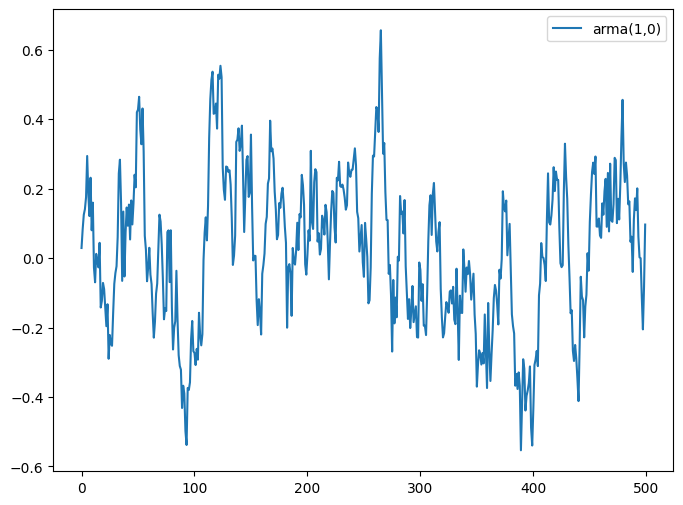

In [6]:
# plot data
df.plot(subplots=True)

In [7]:
df.describe()

,"arma(1,0)"
count,500.000000
mean,0.022782
std,0.216686
min,-0.553417
25%,-0.135661
50%,0.034751
75%,0.174298
max,0.656173


### Split the data (70% - 20% - 10%), consecutive...

In [8]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]
print('num_features: ', num_features)

num_features:  1


In [9]:
train_df.describe().transpose() # train set statistics

,count,mean,std,min,25%,50%,75%,max
"arma(1,0)",350.0,0.048964,0.207174,-0.538181,-0.106103,0.047874,0.186389,0.656173


### Normalize data

In [10]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

/var/folders/_v/lgpm88ls0w9f4nmn4plh963m0000gn/T/ipykernel_5047/491146181.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  _ = ax.set_xticklabels(df.keys(), rotation=90)


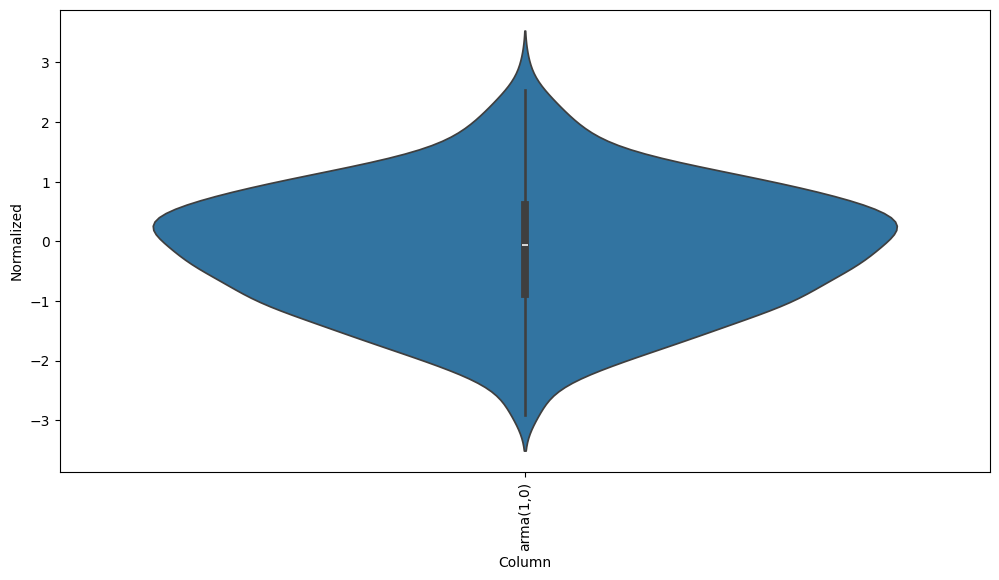

In [11]:
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized') # this dataframe has 2 columns: Column and Normalized
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

### visualize prior to standardization

/var/folders/_v/lgpm88ls0w9f4nmn4plh963m0000gn/T/ipykernel_5047/2716101140.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  _ = ax.set_xticklabels(train_df.keys(), rotation=90)


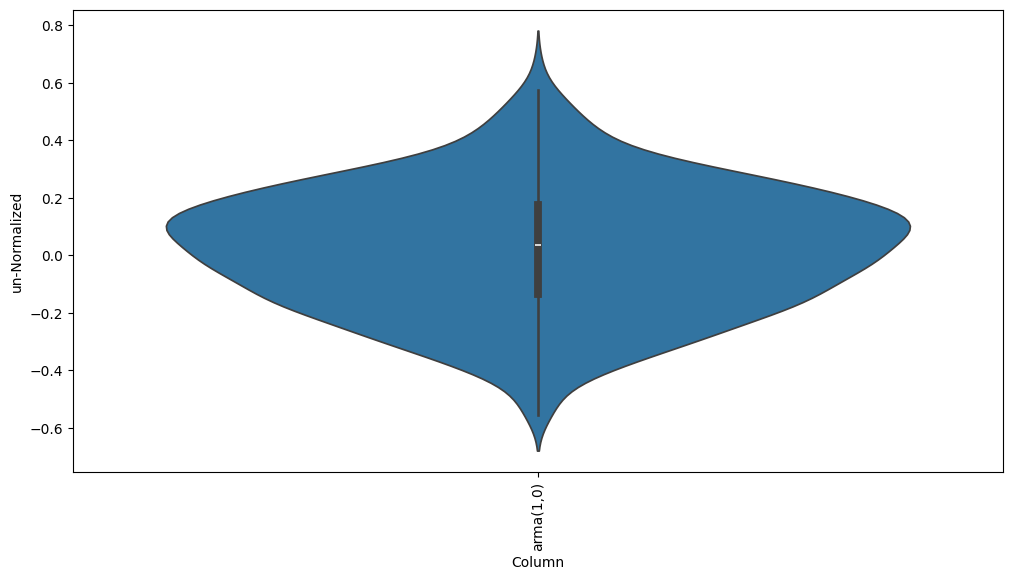

In [12]:
train_df_unnormalized = df.melt(var_name='Column', value_name='un-Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='un-Normalized', data=train_df_unnormalized)
_ = ax.set_xticklabels(train_df.keys(), rotation=90)

## Data windowing 
attributes:
* input length: in time-steps
* offset: difference of input from label in time-steps
* label: future value length in time-steps

eg. (9, 1, 1) --> 9 days to predict the 10-th day

#### Window class
  Takes the training, evaluation, and test DataFrames as input. 
  These will be converted to `tf.data.Dataset`s of windows in make_dataset().

In [13]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])
  
  def split_window(self, features):
    """
        split window into input (time-steps) and label (time-steps)
    """
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    if self.label_columns is not None:
        labels = tf.stack(
            [labels[:, :, self.column_indices[name]] for name in self.label_columns],
            axis=-1)

    # Slicing doesn't preserve static shape information, so set the shapes
    # manually. This way the `tf.data.Datasets` are easier to inspect.
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])

    return inputs, labels


  def plot(self, model=None, plot_col='arma(1,0)', max_subplots=3):
    """
        plot window object, with max_subplots number of batches of a specific column
        Optionally, a model can be passed.
        default plot_col name is always 'arma(1,0)'
    """
    inputs, labels = self.example
    plt.figure(figsize=(12, 8))
    plot_col_index = self.column_indices[plot_col]
    max_n = min(max_subplots, len(inputs))
    for n in range(max_n):
      plt.subplot(max_n, 1, n+1)
      plt.ylabel(f'{plot_col} [standardized]') # <-- check this if I remove standardization
      plt.plot(self.input_indices, inputs[n, :, plot_col_index],
              label='Inputs', marker='.', zorder=-10)

      if self.label_columns:
        label_col_index = self.label_columns_indices.get(plot_col, None)
      else:
        label_col_index = plot_col_index

      if label_col_index is None:
        continue

      plt.scatter(self.label_indices, labels[n, :, label_col_index],
                  edgecolors='k', label='Labels', c='#2ca02c', s=64)
      if model is not None:
        predictions = model(inputs)
        plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                    marker='X', edgecolors='k', label='Predictions',
                    c='#ff7f0e', s=64)

      if n == 0:
        plt.legend()

    plt.xlabel('Time-step')
    

  def make_dataset(self, data):
    """
          time series DataFrame and convert it to a tf.data.Dataset of (input_window, label_window)
          This is the most important function as it calls the keras util function fot timeseries splitting.

          NOTE: is is constrained by total_window_size.
    """
    data = np.array(data, dtype=np.float32)  # axis 0 is the time dimension
    ds = tf.keras.utils.timeseries_dataset_from_array(
        data=data,
        targets=None,
        sequence_length=self.total_window_size,
        sequence_stride=1, # next sequence is batch shifted by 1 to the right
        shuffle=True, # TODO CHECK!!
        batch_size=32,)  

    # this returns a tf.data.Dataset of (input_window, label_window) pairs!
    ds = ds.map(self.split_window)  # NOTE that although targets=None above, the split_window takes care of returning the target labels ;)

    return ds


  """
    Properties for accessing them as tf.data.Datasets using the make_dataset method defined earlier.
    Also, add a standard example batch for easy access and plotting.
  """
  @property
  def train(self):
    return self.make_dataset(self.train_df)

  @property
  def val(self):
    return self.make_dataset(self.val_df)

  @property
  def test(self):
    return self.make_dataset(self.test_df)

  @property
  def example(self):
    """Get and cache an example batch of `inputs, labels` for plotting or just a fwd pass before training."""
    result = getattr(self, '_example', None)
    if result is None:
      # No example batch was found, so get one from the `.train` dataset
      result = next(iter(self.train))
      # And cache it for next time
      self._example = result
    return result



In [14]:
# w1 = WindowGenerator(input_width=9, label_width=1, shift=1,
#                      label_columns=['arma(1,0)'])

w1 = WindowGenerator(input_width=9, label_width=1, shift=1,
                    train_df=train_df, val_df=val_df, test_df=test_df,
                    label_columns=[train_df.columns[0]])# label_columns=['arma(1,0)'])
w1

Total window size: 10
Input indices: [0 1 2 3 4 5 6 7 8]
Label indices: [9]
Label column name(s): ['arma(1,0)']

In [15]:
# Stack 3 slices ('windows' of offset by 100 time-steps), of length == total window.
example_window = tf.stack([np.array(train_df[:w1.total_window_size]),
                           np.array(train_df[100:100+w1.total_window_size]),
                           np.array(train_df[200:200+w1.total_window_size])])

example_inputs, example_labels = w1.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}') # batch x (len(input) + len(label)) x features
print(f'Inputs shape: {example_inputs.shape}') 
print(f'Labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 10, 1)
Inputs shape: (3, 9, 1)
Labels shape: (3, 1, 1)


2023-11-15 16:27:07.244812: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


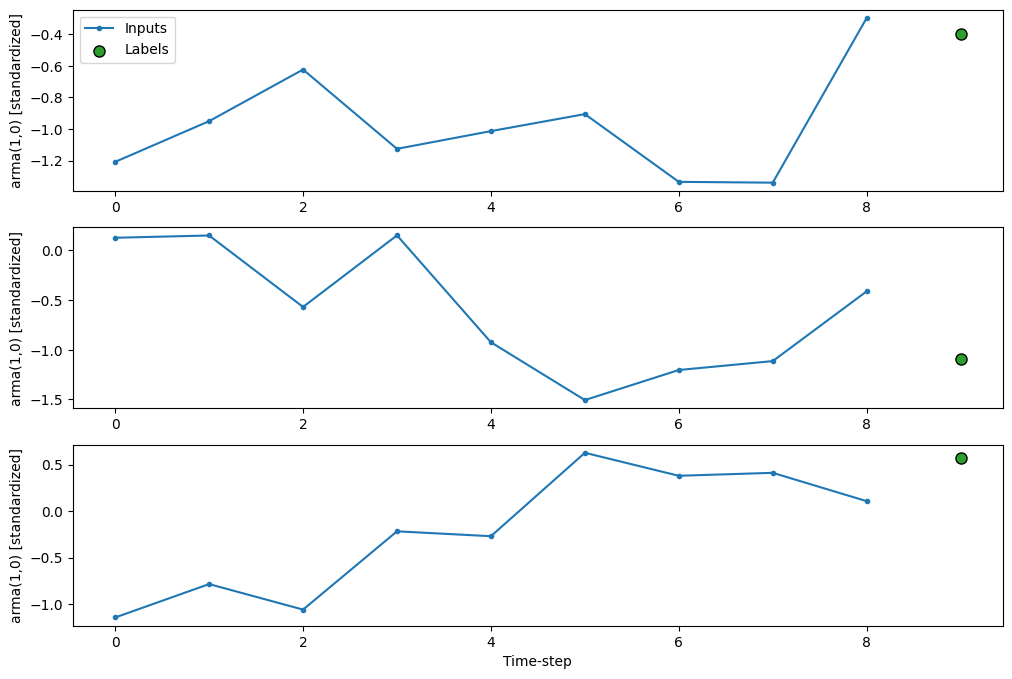

In [16]:
# example_inputs --> tensor 

# add the inputs and labels to the window for plotting...
# w1.example = example_inputs, example_labels
# w1.plot()
w1.plot(plot_col= w1.train_df.columns[0])

In [17]:
w1.train.element_spec # verify the dataset is tensor

(TensorSpec(shape=(None, 9, 1), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

In [18]:
# w1.train_df # original data in dataframe

In [19]:
# w1.example

In [20]:
# check that sampling (a predefined batch size) works
for example_inputs, example_labels in w1.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 9, 1)
Labels shape (batch, time, features): (32, 1, 1)


## Model: Transformer

### Vanilla Positional Encoding ("FixedPositionalEncoding" in TST --> alternatively "LearnablePositionalEncoding")
$$\Large{PE_{(pos, 2i)} = \sin(pos / 10000^{2i / d_{model}})} $$
$$\Large{PE_{(pos, 2i+1)} = \cos(pos / 10000^{2i / d_{model}})} $$

In [21]:
def positional_encoding(length, depth):
  depth = depth/2

  positions = np.arange(length)[:, np.newaxis]     # (seq, 1)
  depths = np.arange(depth)[np.newaxis, :]/depth   # (1, depth)

  angle_rates = 1 / (10000**depths)         # (1, depth)
  angle_rads = positions * angle_rates      # (pos, depth)

  pos_encoding = np.concatenate(
      [np.sin(angle_rads), np.cos(angle_rads)],
      axis=-1)

  return tf.cast(pos_encoding, dtype=tf.float32)

### Input Embedding

In [22]:
class PositionalEmbedding(tf.keras.layers.Layer):
  def __init__(self, vocab_size, d_model):
    super().__init__()
    self.d_model = d_model
    # self.embedding = tf.keras.layers.Embedding(vocab_size, d_model, mask_zero=True) # ORIGINAL!
    # use this instead (inspired by TST)
    self.embedding = tf.keras.layers.Dense(units=d_model,
                                           activation=None,
                                           use_bias=True
                                           ) # nn.Linear(feat_dim, d_model)
    
    self.pos_encoding = positional_encoding(length=2048, depth=d_model) # TODO check this length!

  def compute_mask(self, *args, **kwargs):
    return self.embedding.compute_mask(*args, **kwargs)

  def call(self, x):
    length = tf.shape(x)[1]
    x = self.embedding(x)
    # This factor sets the relative scale of the embedding and positonal_encoding.
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x = x + self.pos_encoding[tf.newaxis, :length, :]
    return x

In [23]:

class CausalSelfAttention(tf.keras.layers.Layer):
  def __init__(self, **kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
    self.layernorm = tf.keras.layers.LayerNormalization()
    self.add = tf.keras.layers.Add()

  def call(self, x):
    attn_output = self.mha(
        query=x,
        value=x,
        key=x,
        use_causal_mask = True)
    
    x = self.add([x, attn_output])

    x = self.layernorm(x) # check if needed...

    return x

In [24]:
class FeedForward(tf.keras.layers.Layer):
  def __init__(self, d_model, dff, dropout_rate=0.1):
    super().__init__()
    self.seq = tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),
      tf.keras.layers.Dense(d_model),
      tf.keras.layers.Dropout(dropout_rate)
    ])
    self.add = tf.keras.layers.Add()
    self.layer_norm = tf.keras.layers.LayerNormalization() # TODO: maybe swap with batch norm

  def call(self, x):
    x = self.add([x, self.seq(x)])
    x = self.layer_norm(x) 
    return x

In [25]:
# modification to the vanilla DeocderLayer --> CausalSelfAttention only
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self,
               *,
               d_model,
               num_heads,
               dff,
               dropout_rate=0.1):
    super(DecoderLayer, self).__init__()

    self.causal_self_attention = CausalSelfAttention( # TODO: check if this is enough in contrast to TST
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)

    # self.cross_attention = CrossAttention(
    #     num_heads=num_heads,
    #     key_dim=d_model,
    #     dropout=dropout_rate)

    self.ffn = FeedForward(d_model, dff)

  def call(self, x): # , context):
    x = self.causal_self_attention(x=x)
    # x = self.cross_attention(x=x, context=context)

    # Cache the last attention scores for plotting later
    # self.last_attn_scores = self.cross_attention.last_attn_scores

    x = self.ffn(x)  # Shape `(batch_size, seq_len, d_model)`.
    return x

In [26]:
# original tutorial implementation 
class Decoder(tf.keras.layers.Layer):
  def __init__(self, *, num_layers, d_model, num_heads, dff, vocab_size,
               dropout_rate=0.1):
    super(Decoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.pos_embedding = PositionalEmbedding(vocab_size=vocab_size,
                                             d_model=d_model)
    self.dropout = tf.keras.layers.Dropout(dropout_rate)
    self.dec_layers = [
        DecoderLayer(d_model=d_model, num_heads=num_heads,
                     dff=dff, dropout_rate=dropout_rate)
        for _ in range(num_layers)]

    # self.last_attn_scores = None

  def call(self, x): #, context):
    # `x` is token-IDs shape (batch, target_seq_len)
    x = self.pos_embedding(x)  # (batch_size, target_seq_len, d_model)

    x = self.dropout(x)

    for i in range(self.num_layers):
      x  = self.dec_layers[i](x) #, context)

    # self.last_attn_scores = self.dec_layers[-1].last_attn_scores

    # The shape of x is (batch_size, target_seq_len, d_model).
    return x

In [27]:
# # 1-layer decoder
# class Decoder(tf.keras.layers.Layer):  
#     def __init__(self, *,
#                  num_layers,
#                d_model,
#                num_heads,
#                dff, 
#                vocab_size,
#                dropout_rate=0.1):
#         super(Decoder, self).__init__()

#         # positional embedding!
#         # self.pos_embedding =...

#         self.CSA = CausalSelfAttention(num_heads=2, key_dim=2)
#         self.ffn = FeedForward(d_model=2, dff=9) # <-- d_model is set to same as CSA heads... dff is the length of the encoding
        
        

#     def call(self, inputs):

#         # x = self.pos_embedding(x)
        
#         x = self.CSA(inputs)

#         x = self.ffn(x)  

#         return x

In [28]:
class Transformer(tf.keras.Model):
    def __init__(self, *, num_layers, d_model, num_heads, dff,
               input_vocab_size, target_vocab_size, dropout_rate=0.1):
        super().__init__()

        self.decoder = Decoder(num_layers=num_layers, d_model=d_model,
                            num_heads=num_heads, dff=dff,
                            vocab_size=target_vocab_size,
                            dropout_rate=dropout_rate)

        self.final_layer = tf.keras.layers.Dense(units=1)  #  <--- CHECK!!     # (target_vocab_size)


    def call(self, inputs):
        # To use a Keras model with `.fit` you must pass all your inputs in the
        # first argument.
        
        # context, x  = inputs # this was for cross_attention in the original Decoder formulation
        # x = self.decoder(x, context)

        x = self.decoder(inputs) # bs x timesteps x d_model! ie 32 x 9 x 2
        
        # Final linear layer output.
        logits = self.final_layer(x)
        
        return logits

In [29]:
# instantiate the model
transformer_model = Transformer(num_layers=1, # not used, only 1 attention block
                                 d_model=32, # key_dim & FeedForward 2nd Dense units (hardcoded for now!)
                                 num_heads=2, # (hardcoded for now!)
                                 dff=9,  # FeedForward 1st Dense units (hardcoded for now!)
                                 input_vocab_size=1, # for Encoder. Not used here
                                 target_vocab_size=1 # for Decoder, number of classes used in final linear layer
                                 )


In [30]:
# check model input and output shapes
print('Input shape:', w1.example[0].shape)  # bs x input length x features

Input shape: (32, 9, 1)


In [31]:
print('Output shape:', transformer_model(w1.example[0]).shape) # bs x prediction length x features

Output shape: (32, 9, 1)


In [32]:
transformer_model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

In [33]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=2,
                                                    mode='min')

history = transformer_model.fit(w1.train,  # make_dataset for windowing data is invoked here!
                          epochs= 40, #20,
                          validation_data=w1.val,
                          callbacks=[early_stopping]
                          )

Epoch 1/40
11/11 [==============================] - 1s 26ms/step - loss: 1.6949 - mean_absolute_error: 1.0403 - val_loss: 0.9537 - val_mean_absolute_error: 0.8067
Epoch 2/40
11/11 [==============================] - 0s 5ms/step - loss: 1.0933 - mean_absolute_error: 0.8309 - val_loss: 1.1452 - val_mean_absolute_error: 0.8535
Epoch 3/40
11/11 [==============================] - 0s 6ms/step - loss: 0.9811 - mean_absolute_error: 0.7931 - val_loss: 0.9894 - val_mean_absolute_error: 0.8042


## use the un-shuffled test set for plotting

In [34]:
tmp_data =  np.array(test_df['arma(1,0)'].tolist()) # np.arange(0,100)
# input_data = tmp_data[:-1] # this MUST MATCH the prediction length!!
# targets = tmp_data[9:] # this will not be used for predictions but needed for next

# attempt to add a dimension (needed for forward pass in transformer)!
tmp_data = np.expand_dims(tmp_data, axis=-1)
input_data = tmp_data[:-1, :] # this MUST MATCH the prediction length!!
targets = tmp_data[9:, :] # this will not be used for predictions but needed for next


tmp_ds_9 = tf.keras.utils.timeseries_dataset_from_array(
    data=input_data,
    targets=targets,
    sequence_length= 9, # this must match the input length of the window!
    sequence_stride=1, # next sequence is batch shifted by 1 to the right
    shuffle=False, # no shuffling in test set!
    batch_size=1 # 10,
    )  

In [35]:
# i = 0 
# for batch in tmp_ds_9:
#   cur_inputs, cur_targets = batch

# #   if i == 0:
# #     print(cur_inputs)
# #     print('==========')
# #     print(cur_targets)

#   i += 1
#   # if i > 1:
#   #   break

# print('i: ', i)
# print(cur_inputs)
# print('==========')
# print(cur_targets)

In [36]:
input_data.shape

(49, 1)

# CHECK the dimensions!

In [37]:
tmp_ds_9

<BatchDataset element_spec=(TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None), TensorSpec(shape=(None, 1), dtype=tf.float64, name=None))>

### The transformer expects bs x timesteps x features (or emb dims)
    here features is 1 (1-d process, without embedding)

In [38]:
# dummy = tf.expand_dims(tmp_ds_9, axis=-1)
# dummy

In [39]:
tmp_preds = transformer_model.predict(tmp_ds_9)

41/41 [==============================] - 0s 630us/step


In [40]:
tmp_preds.shape

(41, 9, 1)

In [41]:
display(tmp_preds[0,:,:])
display(tmp_preds[1,:,:])

array([[-0.05166909],
       [ 0.1787819 ],
       [ 0.40810177],
       [ 0.5027796 ],
       [ 0.46435416],
       [ 0.41977564],
       [ 0.09535208],
       [ 0.05370018],
       [ 0.14887336]], dtype=float32)

array([[0.04911133],
       [0.22578868],
       [0.3839211 ],
       [0.44320697],
       [0.47321784],
       [0.20758078],
       [0.0936344 ],
       [0.09074059],
       [0.06657472]], dtype=float32)

### plot the **final** preds of the timeseries

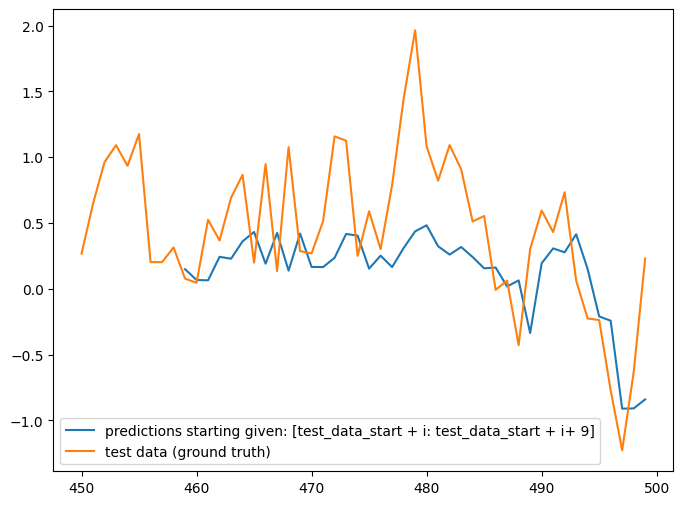

In [42]:
plt.plot(np.arange(459,500), tmp_preds[:,-1,0], label='predictions starting given: [test_data_start + i: test_data_start + i+ 9]')
plt.plot(test_df, label='test data (ground truth)')

# plt.plot(w1.test_df, 'o', label='test data (window object)') # CHECK: are the data inside the w1 object correct????
plt.legend()

### Evaluate performance on val set

In [43]:
val_performance = {} # on validation set, for MSE (target loss) and MAE (target metric)
performance = {} # on test set, for MSE and MAE

val_performance['transformer_model_9'] = transformer_model.evaluate(w1.val)
performance['transformer_model_9'] = transformer_model.evaluate(w1.test, verbose=1)

2/2 [==============================] - 0s 3ms/step - loss: 0.3987 - mean_absolute_error: 0.4916


In [44]:
val_performance

{'transformer_model_9': [0.9894464612007141, 0.8041701316833496]}

In [45]:
performance

{'transformer_model_9': [0.39865541458129883, 0.49158814549446106]}

### make predictions

In [46]:
preds = transformer_model.predict(w1.test)

2/2 [==============================] - 0s 2ms/step


In [47]:
# we need #input time-steps in order to make #labels predictions
# e.g. for input_width=9, label_width=1, shift=1 and 50 test samples, we have 50-9-1+1 = 41 predictions!
preds.shape 

(41, 9, 1)

In [48]:
# shape of df_test
test_df.shape

(50, 1)

### plot the results
## NOTE: I plot the last prediction only if return_sequences==True! (CHECK)

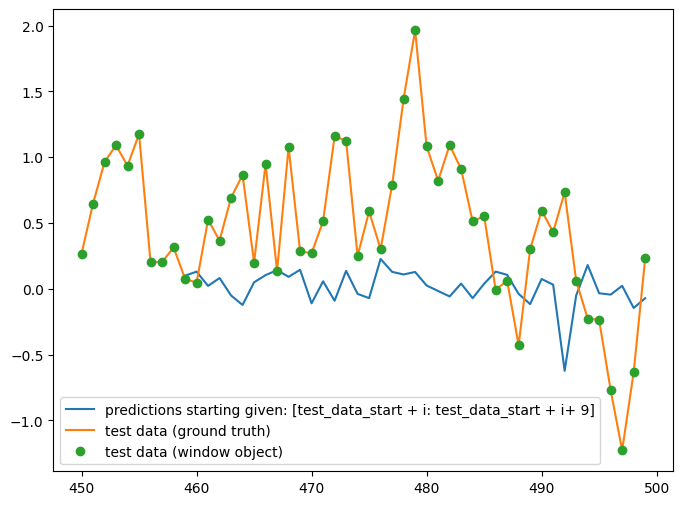

In [49]:
# plt.plot(preds[0,:,0], label='prediction for 49')
# plt.plot(preds[1,:,0], label='prediction for 49')

# plt.plot(np.arange(459,500), preds[:,0,0], label='predictions starting given: [test_data_start + i: test_data_start + i+ 9]')
# plt.plot(np.arange(459,500), preds[:,-1,0], label='predictions starting given: [test_data_start + i: test_data_start + i+ 9]')
plt.plot(np.arange(459,500), preds[:,0], label='predictions starting given: [test_data_start + i: test_data_start + i+ 9]')


plt.plot(test_df, label='test data (ground truth)')

plt.plot(w1.test_df, 'o', label='test data (window object)') # CHECK: are the data inside the w1 object correct????

plt.legend()

In [50]:

# stop





## Example 2: window of size 19 inputs and 1 ouput

In [51]:
w2 =  WindowGenerator(input_width=19, label_width=1, shift=1,
                    train_df=train_df, val_df=val_df, test_df=test_df,
                    label_columns=[train_df.columns[0]])
w2

Total window size: 20
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18]
Label indices: [19]
Label column name(s): ['arma(1,0)']

In [52]:
# sanity check
for example_inputs, example_labels in w2.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 19, 1)
Labels shape (batch, time, features): (32, 1, 1)


In [53]:
# TODO: write functional model with init() and instantiate otherwise I have to re-dectlare the model


lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=False), #return_sequences=True),  # CHECK <---------!!!!!!!!!!!!
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

# re-check model input and output shapes
print('Input shape:', w2.example[0].shape)  # bs x input length x features
print('Output shape:', lstm_model(w2.example[0]).shape) # bs x prediction length x features

Input shape: (32, 19, 1)
Output shape: (32, 1)


In [54]:
lstm_model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

In [55]:
history = lstm_model.fit(w2.train,  # make_dataset for windowing data is invoked here!
                          epochs= 40, #20,
                          validation_data=w2.val,
                          callbacks=[early_stopping]
                          )

Epoch 1/40
11/11 [==============================] - 1s 37ms/step - loss: 1.0844 - mean_absolute_error: 0.8437 - val_loss: 1.3787 - val_mean_absolute_error: 0.9638
Epoch 2/40
11/11 [==============================] - 0s 5ms/step - loss: 0.8494 - mean_absolute_error: 0.7468 - val_loss: 1.0719 - val_mean_absolute_error: 0.8621
Epoch 3/40
11/11 [==============================] - 0s 5ms/step - loss: 0.7126 - mean_absolute_error: 0.6841 - val_loss: 0.8769 - val_mean_absolute_error: 0.8054
Epoch 4/40
11/11 [==============================] - 0s 5ms/step - loss: 0.6332 - mean_absolute_error: 0.6414 - val_loss: 0.7535 - val_mean_absolute_error: 0.7397
Epoch 5/40
11/11 [==============================] - 0s 5ms/step - loss: 0.5682 - mean_absolute_error: 0.6099 - val_loss: 0.6406 - val_mean_absolute_error: 0.6806
Epoch 6/40
11/11 [==============================] - 0s 5ms/step - loss: 0.5090 - mean_absolute_error: 0.5787 - val_loss: 0.5517 - val_mean_absolute_error: 0.6238
Epoch 7/40
11/11 [=========

In [56]:
val_performance['Dense_input_19'] = lstm_model.evaluate(w2.val)
performance['Dense_input_19'] = lstm_model.evaluate(w2.test, verbose=1)

1/1 [==============================] - 0s 24ms/step - loss: 0.2476 - mean_absolute_error: 0.4161


In [57]:
print('val set performance:')
display(val_performance)

print('test set performance:')
display(performance)

val set performance:


{'transformer_model_9': [0.9894464612007141, 0.8041701316833496],
 'Dense_input_19': [0.24461275339126587, 0.3870382606983185]}

test set performance:


{'transformer_model_9': [0.39865541458129883, 0.49158814549446106],
 'Dense_input_19': [0.2475873827934265, 0.4160653352737427]}

In [58]:
preds = lstm_model.predict(w2.test)

1/1 [==============================] - 0s 204ms/step


## NOTE: I plot the last prediction if return_sequences=True (CHECK!)

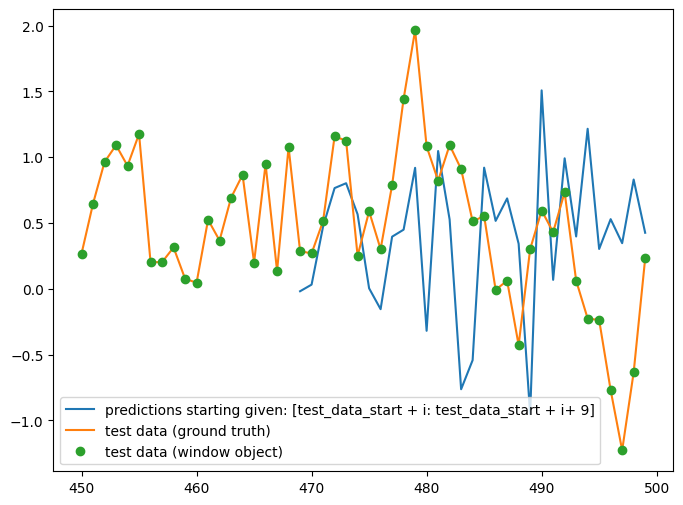

In [59]:
# plt.plot(np.arange(450+19,500), preds[:,0,0], label='predictions starting given: [test_data_start + i: test_data_start + i+ 9]')
plt.plot(np.arange(450+19,500), preds[:,0], label='predictions starting given: [test_data_start + i: test_data_start + i+ 9]')

plt.plot(test_df, label='test data (ground truth)')

plt.plot(w1.test_df, 'o', label='test data (window object)') # CHECK: are the data inside the w1 object correct????

plt.legend()